<a href="https://colab.research.google.com/github/ristacp10/Analisis-Sentimen-Berbasis-Aspek-Pada-Aplikasi-Soco-Menggunakan-Bidirectional-Long-Short-Term-Memory/blob/main/Model_Selection_Aspek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir CSV
!wget -P CSV/ https://raw.githubusercontent.com/ristacp10/Analisis-Sentimen-Berbasis-Aspek-Pada-Aplikasi-Soco-Menggunakan-Bidirectional-Long-Short-Term-Memory/main/CSV/PREPROSS.csv

--2021-08-13 17:05:45--  https://raw.githubusercontent.com/ristacp10/Analisis-Sentimen-Berbasis-Aspek-Pada-Aplikasi-Soco-Menggunakan-Bidirectional-Long-Short-Term-Memory/main/CSV/PREPROSS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333914 (326K) [text/plain]
Saving to: ‘CSV/PREPROSS.csv’

PREPROSS.csv        100%[===================>] 326.09K  --.-KB/s    in 0.03s   

2021-08-13 17:05:45 (9.49 MB/s) - ‘CSV/PREPROSS.csv’ saved [333914/333914]



In [2]:
!pip install graphviz dtreeviz
import numpy as np
import tensorflow as tf
import nltk, pandas as pd; nltk.download('popular')
import graphviz, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from sklearn import svm
from sklearn.svm import SVC
import sklearn.metrics as metric
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from pandas.plotting import scatter_matrix 
from sklearn import model_selection, tree
from sklearn import tree
from dtreeviz.trees import *
from IPython.core.display import display, HTML
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
sns.set(style="ticks", color_codes=True)

     |████████████████████████████████| 60 kB 3.3 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66637 sha256=d54a44120378a12f49891fd2760fd88031b73cd08bb3a49d7d2b9a87f1f0aef6
  Stored in directory: /root/.cache/pip/wheels/9f/a6/a1/898c991294471015f13c1e5b456fb8134c1af835db4dd93a7a
Successfully built dtreeviz
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.

In [3]:
names = ['At','Sentimen', 'Review', 'Bintang', 'Aspek', 'data_cleaned_aspek']
file = 'CSV/PREPROSS.csv'
 
try:
  data = pd.read_csv(file)
except:
  data = pd.read_csv(file, names=names).values

dataset = pd.DataFrame()
dataset = pd.DataFrame()
dataset['data_cleaned_aspek'] = data['data_cleaned_aspek'].tolist()
dataset['Aspek'] = data['Aspek'].tolist()
dataset.head()

,data_cleaned_aspek,Aspek
0,good,Lainnya
1,belanja original bayar diskon responsif metode...,Layanan
2,kecewa cancel kosong proses uang sulit check o...,Layanan
3,parah proses refund masuk kerja uang 775 43...,Layanan
4,product tanggal 11 september udah 16 oktob...,Layanan


# **BIDIRECTIONAL LSTM**

In [4]:
labels = dataset['Aspek'].tolist()
articles = dataset['data_cleaned_aspek'].astype(str).tolist()

In [5]:
vocab_size = 5000
embedding_dim = 16
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [6]:
# Simple Split ... sebaiknya CV dan gunakan fungsi pisah train-test (misal sklearn)
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [7]:
# Siapkan Struktur Data Training Data
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Siapkan Struktur Data Test Data
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Siapkan Struktur data untuk Sentimen (perhatikan pada contoh ini sentimen adalah string)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

'Done'

'Done'

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
print(model.summary())
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 84,837
Trainable params: 84,837
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)
lstm = history.history['accuracy']

Epoch 1/10
52/52 - 9s - loss: 1.4358 - accuracy: 0.4843 - val_loss: 1.0643 - val_accuracy: 0.6193
Epoch 2/10
52/52 - 5s - loss: 1.1235 - accuracy: 0.5881 - val_loss: 0.9319 - val_accuracy: 0.6627
Epoch 3/10
52/52 - 5s - loss: 0.9525 - accuracy: 0.6309 - val_loss: 0.8840 - val_accuracy: 0.6795
Epoch 4/10
52/52 - 5s - loss: 0.8315 - accuracy: 0.6858 - val_loss: 0.8205 - val_accuracy: 0.6892
Epoch 5/10
52/52 - 5s - loss: 0.6979 - accuracy: 0.7497 - val_loss: 0.7731 - val_accuracy: 0.7181
Epoch 6/10
52/52 - 5s - loss: 0.5584 - accuracy: 0.7943 - val_loss: 0.7519 - val_accuracy: 0.7108
Epoch 7/10
52/52 - 5s - loss: 0.4664 - accuracy: 0.8166 - val_loss: 0.7703 - val_accuracy: 0.7108
Epoch 8/10
52/52 - 5s - loss: 0.4170 - accuracy: 0.8281 - val_loss: 0.8007 - val_accuracy: 0.6988
Epoch 9/10
52/52 - 5s - loss: 0.3721 - accuracy: 0.8456 - val_loss: 0.7603 - val_accuracy: 0.7349
Epoch 10/10
52/52 - 5s - loss: 0.3359 - accuracy: 0.8709 - val_loss: 0.7949 - val_accuracy: 0.7349


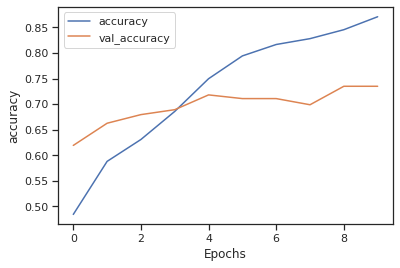

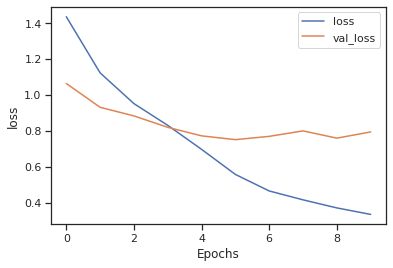

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
data_cleaned = articles
seq = tokenizer.texts_to_sequences(data_cleaned)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
Aspek = labels
print(pred, Aspek[np.argmax(pred)])

IndexError: ignored

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred = model.predict(validation_padded)
print('Akurasi = ', accuracy_score(validation_label_seq, pred.argmax(axis=1)))
print(confusion_matrix(validation_label_seq, pred.argmax(axis=1)))
print(classification_report(validation_label_seq, pred.argmax(axis=1)))

Akurasi =  0.7349397590361446
[[180  23  10   1]
 [ 55  99   2   2]
 [  9   1  14   2]
 [  1   2   2  12]]
              precision    recall  f1-score   support

           1       0.73      0.84      0.78       214
           2       0.79      0.63      0.70       158
           3       0.50      0.54      0.52        26
           4       0.71      0.71      0.71        17

    accuracy                           0.73       415
   macro avg       0.68      0.68      0.68       415
weighted avg       0.74      0.73      0.73       415



# **KNN**

In [15]:
# Optimal parameter k-NN dengan GRIDSEARCH
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

kCV = 10
metric = 'accuracy'
params = {}
params['tfidfvectorizer__min_df'] = [10]
params['tfidfvectorizer__max_df'] = [0.5]
params['tfidfvectorizer__smooth_idf'] = [False]
params['tfidfvectorizer__sublinear_tf'] = [True]
params['tfidfvectorizer__ngram_range'] = [(1, 1)]
params['kneighborsclassifier__n_neighbors'] = [5]
params['kneighborsclassifier__weights'] = ('distance', 'uniform')

pipe = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
gridCV = GridSearchCV(pipe, params, cv=kCV, scoring=metric, verbose=1, n_jobs=-1)
gridCV.fit(X_train, y_train)
print(gridCV.best_score_)
print(gridCV.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.7038590726542534
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance', 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': False, 'tfidfvectorizer__sublinear_tf': True}


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


In [16]:
knn_score = gridCV.best_score_
#y_kNN = knn_score.predict(X_test)

#knn_score = accuracy_score(y_test, y_kNN)
print('Akurasi = ', knn_score)
#print(confusion_matrix(y_test, y_kNN))
#print(classification_report(y_test, y_kNN))

Akurasi =  0.7038590726542534


In [17]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, smooth_idf= False, sublinear_tf=True, 
                                   ngram_range=(1, 1), max_df=0.5, min_df=10)

In [18]:
seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train = tfidf_vectorizer.fit_transform(X_train) # "Fit_Transform"
X_test = tfidf_vectorizer.transform(X_test) # Perhatikan disini hanya "Transform"

print(X_train.shape, X_test.shape)

(1658, 147) (415, 147)


In [19]:
def hapusKosong(X,y):
    y = y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)
print(X_train.shape, X_test.shape)

(1581, 147) (391, 147)


In [20]:
model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
kNN = model.fit(X_train, y_train)
y_kNN = kNN.predict(X_test)

print('Akurasi = ', accuracy_score(y_test, y_kNN))
print(confusion_matrix(y_test, y_kNN))
print(classification_report(y_test, y_kNN))

Akurasi =  0.7595907928388747
[[113   2   1  15]
 [ 15  36   4   8]
 [  3   2  14   2]
 [ 34   6   2 134]]
              precision    recall  f1-score   support

     Lainnya       0.68      0.86      0.76       131
     Layanan       0.78      0.57      0.66        63
      Produk       0.67      0.67      0.67        21
    Tampilan       0.84      0.76      0.80       176

    accuracy                           0.76       391
   macro avg       0.74      0.72      0.72       391
weighted avg       0.77      0.76      0.76       391



# **SVM**

In [21]:
# Optimal parameter SVM dengan GRIDSEARCH

seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
paramsSVM = {}
paramsSVM['tfidfvectorizer__min_df'] = [2]
paramsSVM['tfidfvectorizer__max_df'] = [0.5]
paramsSVM['tfidfvectorizer__smooth_idf'] = [True]
paramsSVM['tfidfvectorizer__sublinear_tf'] = [True]
paramsSVM['tfidfvectorizer__ngram_range'] = [(1, 1)]
paramsSVM['svc__C'] = [10] #sp.stats.uniform(scale=1)
paramsSVM['svc__gamma'] = [0.1]
paramsSVM['svc__kernel'] = ['rbf']
paramsSVM['svc__decision_function_shape'] = ['ovo']

pipeSVM = make_pipeline(TfidfVectorizer(), svm.SVC())
gridsvmCV = GridSearchCV(pipeSVM, paramsSVM, cv=kCV, scoring=metric, verbose=1,  n_jobs=-1) # , pre_dispatch='2*n_jobs' pre_dispatch min 2* n_jobs
gridsvmCV.fit(X_train, y_train)
print(gridsvmCV.best_score_)
print(gridsvmCV.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


0.777418765972983
{'svc__C': 10, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True}


In [22]:
svm_score = gridsvmCV.best_score_
#y_pred = dSVM.predict(X_test)

#svm_score = accuracy_score(y_test, y_pred)
print('Akurasi = ', svm_score)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

Akurasi =  0.777418765972983


In [23]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 1), max_df=0.5, min_df=2)

In [25]:
seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train = tfidf_vectorizer.fit_transform(X_train) # "Fit_Transform"
X_test = tfidf_vectorizer.transform(X_test) # Perhatikan disini hanya "Transform"

print(X_train.shape, X_test.shape)

(1658, 661) (415, 661)


In [26]:
def hapusKosong(X,y):
    y = y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)
print(X_train.shape, X_test.shape)

(1642, 661) (407, 661)


In [27]:
kCV = 10
metric = 'accuracy'

dSVM = svm.SVC(C = 10, kernel = 'rbf', gamma = 0.1, decision_function_shape = 'ovo')
dSVM.fit(X_train, y_train)
y_SVM = dSVM.predict(X_test)
print('Akurasi = ', accuracy_score(y_test, y_SVM))
print(confusion_matrix(y_test, y_SVM))
print(classification_report(y_test, y_SVM))

Akurasi =  0.8034398034398035
[[118   4   1  18]
 [ 13  44   2   5]
 [  2   1  14   4]
 [ 22   7   1 151]]
              precision    recall  f1-score   support

     Lainnya       0.76      0.84      0.80       141
     Layanan       0.79      0.69      0.73        64
      Produk       0.78      0.67      0.72        21
    Tampilan       0.85      0.83      0.84       181

    accuracy                           0.80       407
   macro avg       0.79      0.76      0.77       407
weighted avg       0.80      0.80      0.80       407



# **ANN**

In [28]:
# Optimal parameter ANN dengan RandomSEARCH
from sklearn.neural_network import MLPClassifier

seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
paramsNN = {}
paramsNN['tfidfvectorizer__min_df'] = [5]
paramsNN['tfidfvectorizer__max_df'] = [0.95]
paramsNN['tfidfvectorizer__smooth_idf'] = [False]
paramsNN['tfidfvectorizer__sublinear_tf'] = [True]
paramsNN['tfidfvectorizer__ngram_range'] = [(1, 1)]
paramsNN['mlpclassifier__hidden_layer_sizes'] = [(20,30)]
paramsNN['mlpclassifier__learning_rate'] = ['adaptive']
paramsNN['mlpclassifier__activation'] = ['logistic']

pipeNN = make_pipeline(TfidfVectorizer(), MLPClassifier())
randNnCV = RandomizedSearchCV(pipeNN, paramsNN, cv=kCV, scoring=metric, verbose=1, n_iter=30, random_state=seed, n_jobs=-1) # , pre_dispatch='2*n_jobs' pre_dispatch min 2* n_jobs
randNnCV.fit(X_train, y_train)
print(randNnCV.best_score_)
print(randNnCV.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.3s finished


0.7689813800657175
{'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__smooth_idf': False, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__max_df': 0.95, 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__hidden_layer_sizes': (20, 30), 'mlpclassifier__activation': 'logistic'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [29]:
nn_score = randNnCV.best_score_
#y_NN = NN.predict(X_test)

#nn_score = accuracy_score(y_test, y_NN)
print('Akurasi = ', nn_score)
#print(confusion_matrix(y_test, y_NN))
#print(classification_report(y_test, y_NN))

Akurasi =  0.7689813800657175


In [30]:
seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [31]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, smooth_idf= False, sublinear_tf=True, 
                                   ngram_range=(1, 1), max_df=0.95, min_df=5)

X_train = tfidf_vectorizer.fit_transform(X_train) # "Fit_Transform"
X_test = tfidf_vectorizer.transform(X_test) # Perhatikan disini hanya "Transform"

print(X_train.shape, X_test.shape)

(1658, 275) (415, 275)


In [32]:
def hapusKosong(X,y):
    y = y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)
print(X_train.shape, X_test.shape)

(1610, 275) (399, 275)


In [33]:
NN = MLPClassifier(hidden_layer_sizes = (20,30), learning_rate = 'adaptive', activation = 'logistic')
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)

print('Akurasi = ', accuracy_score(y_test, y_NN))
print(confusion_matrix(y_test, y_NN))
print(classification_report(y_test, y_NN))

Akurasi =  0.8120300751879699
[[119   3   0  15]
 [  9  44   3   8]
 [  3   2  13   3]
 [ 17  12   0 148]]
              precision    recall  f1-score   support

     Lainnya       0.80      0.87      0.84       137
     Layanan       0.72      0.69      0.70        64
      Produk       0.81      0.62      0.70        21
    Tampilan       0.85      0.84      0.84       177

    accuracy                           0.81       399
   macro avg       0.80      0.75      0.77       399
weighted avg       0.81      0.81      0.81       399



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# **DECISION TREE**

In [34]:
seed = 99
X = dataset['data_cleaned_aspek'].values.astype('U')
y = dataset['Aspek'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

X_train = tfidf_vectorizer.fit_transform(X_train) # "Fit_Transform"
X_test = tfidf_vectorizer.transform(X_test) # Perhatikan disini hanya "Transform"

print(X_train.shape, X_test.shape)

(1658, 1311) (415, 1311)


In [36]:
def hapusKosong(X,y):
    y = y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)
print(X_train.shape, X_test.shape)

(1642, 1311) (407, 1311)


In [37]:
# Decision Tree Classification
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

dt_score = accuracy_score(y_test, y_dt)
print('Akurasi = ', dt_score)
print(confusion_matrix(y_test, y_dt))
print(classification_report(y_test, y_dt))

Akurasi =  0.7346437346437347
[[122   3   2  14]
 [ 15  33   3  13]
 [  5   3  11   2]
 [ 31  13   4 133]]
              precision    recall  f1-score   support

     Lainnya       0.71      0.87      0.78       141
     Layanan       0.63      0.52      0.57        64
      Produk       0.55      0.52      0.54        21
    Tampilan       0.82      0.73      0.78       181

    accuracy                           0.73       407
   macro avg       0.68      0.66      0.66       407
weighted avg       0.74      0.73      0.73       407



# **RANDOM FOREST**

In [38]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

rf_score = accuracy_score(y_test, y_rf)
print('Akurasi = ', rf_score)
print(confusion_matrix(y_test, y_rf))
print(classification_report(y_test, y_rf))

Akurasi =  0.7862407862407862
[[125   3   0  13]
 [ 13  32   4  15]
 [  5   0  12   4]
 [ 24   4   2 151]]
              precision    recall  f1-score   support

     Lainnya       0.75      0.89      0.81       141
     Layanan       0.82      0.50      0.62        64
      Produk       0.67      0.57      0.62        21
    Tampilan       0.83      0.83      0.83       181

    accuracy                           0.79       407
   macro avg       0.77      0.70      0.72       407
weighted avg       0.79      0.79      0.78       407



# **LOGISTIC REGRESI**

In [39]:
# Logistic Regression

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_clf = clf.predict(X_test)

lr_score = accuracy_score(y_test, y_clf)
print('Akurasi = ', lr_score)
print(confusion_matrix(y_test, y_clf))
print(classification_report(y_test, y_clf))

Akurasi =  0.7813267813267813
[[113   6   0  22]
 [ 14  34   2  14]
 [  5   1  11   4]
 [ 16   5   0 160]]
              precision    recall  f1-score   support

     Lainnya       0.76      0.80      0.78       141
     Layanan       0.74      0.53      0.62        64
      Produk       0.85      0.52      0.65        21
    Tampilan       0.80      0.88      0.84       181

    accuracy                           0.78       407
   macro avg       0.79      0.69      0.72       407
weighted avg       0.78      0.78      0.78       407



# **BOXPLOT SELEKSI MODEL**

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


DT [0.8]
RF [0.8242424242424242]
RL [0.7757575757575758]
k-NN [0.6848484848484848]
SVM [0.8121212121212121]
NN [0.806060606060606]
BiLSTM [0.48431846499443054]


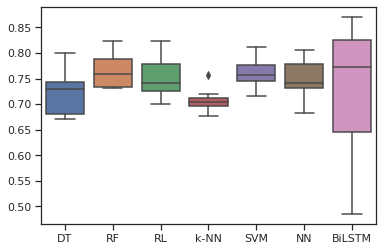

In [40]:
clf = LogisticRegression(solver='liblinear')
kNN = neighbors.KNeighborsClassifier()
dt = tree.DecisionTreeClassifier()
rf = RandomForestClassifier()
Models = [('DT', dt), ('RF', rf),('RL', clf), ('k-NN',kNN), ('SVM', dSVM), ('NN',NN)]
Scores = {}
for model_name, model in Models:
    Scores[model_name] = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
Scores['BiLSTM'] = lstm
dt = pd.DataFrame.from_dict(Scores)
ax = sns.boxplot(data=dt)
for m, s in Scores.items():
    print(m, list(s)[:1])